#Text as Data Coursework. Question Answering

In [1]:
#Install all the necessary dependencies
!pip install scikit-learn
!pip install spacy
!pip install datasets
!python -m spacy download en_core_web_sm
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import spacy

# Load the small english model.
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nlp.remove_pipe('lemmatizer')

('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7b00d80b0a80>)

#Q1 - Dataset and Pre-Process

In [5]:
import json

#Load datasets for train, validation and test
with open("/content/drive/MyDrive/TasD_coursework/train.json") as train_f:
    train_data = json.load(train_f)

with open("/content/drive/MyDrive/TasD_coursework/val.json") as val_f:
    val_data = json.load(val_f)

with open("/content/drive/MyDrive/TasD_coursework/test.json") as test_f:
    test_data = json.load(test_f)
print(train_data)

[{'question': 'how are glacier caves formed?', 'options': ['The ice facade is approximately 60 m high', 'A partly submerged glacier cave on Perito Moreno Glacier .', 'Ice formations in the Titlis glacier cave', 'A glacier cave is a cave formed within the ice of a glacier .'], 'correct_index': 3}, {'question': 'how much is 1 tablespoon of water', 'options': ['In the UK, Europe and most Commonwealth countries, a tablespoon is a type of large spoon usually used for serving.', 'In the US and parts of Canada, a tablespoon is the largest type of spoon used for eating from a bowl.', 'This tablespoon has a capacity of about 15 mL.', 'Measuring Spoons'], 'correct_index': 2}, {'question': 'how much are the harry potter movies worth', 'options': ['Harry Potter is a series of seven fantasy novels written by the British author J. K. Rowling .', "The main story arc concerns Harry's quest to overcome the Dark wizard Lord Voldemort , whose aims are to become immortal, conquer the wizarding world , sub

In [6]:
#define tokenizer function
def text_pipeline_spacy_special(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_punct and not t.is_space:
            tokens.append(t.text.lower())
    return tokens

In [7]:
# (1.1)
num_q_train = len(train_data)
num_answ_train =  np.sum([len(question['options']) for question in train_data])

num_q_val = len(val_data)
num_answ_val =  np.sum([len(question['options']) for question in val_data])

num_q_test = len(test_data)
num_answ_test =  np.sum([len(question['options']) for question in test_data])

print(f"Train : {num_q_train} q, {num_answ_train} answ")
print(f"Validation : {num_q_val} q, {num_answ_val} answ")
print(f"Test : {num_q_test} q, {num_answ_test} answ")

Train : 741 q, 2964 answ
Validation : 103 q, 412 answ
Test : 202 q, 808 answ


In [8]:
for question in tqdm(train_data):
    question['question_tokens'] = text_pipeline_spacy_special(question['question'])
    question['options_tokens'] = [text_pipeline_spacy_special(option) for option in question['options']]


100%|██████████| 741/741 [00:22<00:00, 33.42it/s]


In [9]:
print(question['options_tokens'])
print(question['options'])

[['the', 'housing', 'choice', 'voucher', 'program', 'provides', 'tenant', 'based', 'rental', 'assistance', 'so', 'a', 'tenant', 'can', 'move', 'from', 'one', 'unit', 'of', 'at', 'least', 'minimum', 'housing', 'quality', 'to', 'another'], ['section', '8', 'housing', 'in', 'the', 'south', 'bronx'], ['the', 'us', 'department', 'of', 'housing', 'and', 'urban', 'development', 'manages', 'the', 'section', '8', 'programs'], ['section', '8', 'of', 'the', 'housing', 'act', 'of', '1937', 'often', 'simply', 'known', 'as', 'section', '8', 'as', 'repeatedly', 'amended', 'authorizes', 'the', 'payment', 'of', 'rental', 'housing', 'assistance', 'to', 'private', 'landlords', 'on', 'behalf', 'of', 'approximately', '3.1', 'million', 'low', 'income', 'households']]
['The Housing Choice Voucher Program provides "tenant-based" rental assistance, so a tenant can move from one unit of at least minimum housing quality to another.', 'Section 8 housing in the South Bronx', 'The US Department of Housing and Urban

In [10]:
# (1.2)
avg_token_per_question = sum(len(question['question_tokens']) for question in train_data) / len(train_data)
print('Average number of tokens per question in the training set :', avg_token_per_question)


# (1.3)
num_choices = sum(len(question['options_tokens']) for question in train_data)
num_tokens_in_choices = sum(len(option) for option in question['options_tokens'] for question in train_data)
avg_tokens_per_choice = num_tokens_in_choices / num_choices
print('Average number of tokens per choice in the training set :' , avg_tokens_per_choice)

# (1.4)
correct_choice_tokens = [question['options_tokens'][question['correct_index']] for question in train_data]
avg_tokens_correct_choice = sum(len(option) for option in correct_choice_tokens) / len(correct_choice_tokens)
print('Average number of tokens per correct choice in the training set', avg_tokens_correct_choice)

Average number of tokens per question in the training set : 6.272604588394062
Average number of tokens per choice in the training set : 20.5
Average number of tokens per correct choice in the training set 26.032388663967613


In [11]:
# (1.5) Perform additional exploration

In [12]:
from collections import Counter

#Calculate number of options per question in train data
options_per_question = Counter([len(question['options']) for question in train_data])

print(options_per_question)

#Thus, we check that each of 741 questions has exactly 4 options

Counter({4: 741})


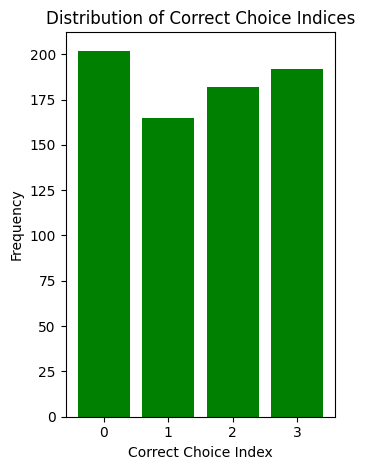

In [13]:
#Calculate the distribution of the correct choice indices
correct_choice_indices_counter = Counter([question['correct_index'] for question in train_data])

plt.subplot(1, 2, 2)
plt.bar(correct_choice_indices_counter.keys(), correct_choice_indices_counter.values(), color='green')
plt.title('Distribution of Correct Choice Indices')
plt.xlabel('Correct Choice Index')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#From plot below we see that indices of correct options are fairly distributed, each question have equal chance to be correct

In [15]:
#Calculate word counts to understand the frequency of tokens inт question and option
def calculate_token_frequences(data):
  word_counts = {'question': Counter(), 'options': Counter()}

  for item in data:

    question_tokens = text_pipeline_spacy_special(item['question'])
    word_counts['question'].update(question_tokens)

    for option in item['options']:
        option_tokens = text_pipeline_spacy_special(option)
        word_counts['options'].update(option_tokens)

  return word_counts


data = calculate_token_frequences(train_data)
print(data)


{'question': Counter({'what': 392, 'is': 304, 'the': 254, 'in': 130, 'how': 116, 'who': 101, 'of': 94, 'a': 91, 'when': 81, 'are': 72, 'did': 66, 'does': 64, 'was': 63, 'where': 60, 'many': 47, 'do': 33, 'for': 32, 'to': 27, 'made': 24, "'s": 22, 'from': 21, 'and': 19, 'on': 19, 'mean': 19, 'war': 18, 'have': 16, 'state': 16, 'name': 16, 'an': 16, 'used': 14, 'first': 14, 'world': 13, 'county': 12, 'year': 12, 'president': 11, 'country': 11, 'much': 10, 'us': 10, 'start': 10, 'die': 9, 'at': 9, 'old': 8, 'it': 8, 'with': 8, 'song': 8, 'people': 7, 'there': 7, 'has': 7, 'as': 7, 'civil': 7, 'wrote': 7, 'come': 7, 'won': 7, 'be': 6, 'work': 6, 'countries': 6, 'day': 6, 'you': 6, 'new': 6, 'american': 6, 'human': 6, 'my': 6, 'states': 6, 'causes': 6, 'created': 6, 'located': 6, 'owns': 6, 'john': 6, 'long': 5, 'singer': 5, 'live': 5, 'group': 5, 'killed': 5, 'kind': 5, 'invented': 5, 'most': 5, 'begin': 5, 'born': 5, 'disease': 5, '1': 4, 'water': 4, 'harry': 4, 'can': 4, 'nixon': 4, 'wer

#Q2 - Set Similarity Measures

In [16]:
#(2.1)
from collections import Counter

#Define functions for each similarity measure

def overlap_coefficient(tokens_X,tokens_Y):
  set_X = set(tokens_X)
  set_Y = set(tokens_Y)
  intersection = set_X.intersection(set_Y)
  return len(intersection)/ min(len(set_X), len(set_Y))

def sorenson_dice(tokens_X,tokens_Y):
  set_X = set(tokens_X)
  set_Y = set(tokens_Y)

  intersection = set_X.intersection(set_Y)
  return 2 * len(intersection)/ (len(set_X) + len(set_Y))

def jaccard_similarity(tokens_X, tokens_Y):
  set_X = set(tokens_X)
  set_Y = set(tokens_Y)

  intersection = set_X.intersection(set_Y)
  union = set_X.union(set_Y)
  return len(intersection)/ len(union)

#Function which calculates similarity measures of each queestion and its 4 options
#Return list of all similarities and index of option with highest simjilarity
def calc_similarity_i(question_tokens, options_tokens, sim_measure):
  similarities = []
  for option in options_tokens:
    if sim_measure == 'overlap':
      similarities.append(overlap_coefficient(question_tokens, option))
    elif sim_measure == 'dice':
      similarities.append(sorenson_dice(question_tokens, option))
    if sim_measure == 'jaccard':
      similarities.append(jaccard_similarity(question_tokens, option))
  highest_i = np.argmax(similarities)
  return highest_i, similarities

#Function To evaluate performance accuracy on the training and validation sets
def perform_train_val(data, function, sim_measure = None):
  correct_predictions = 0
  tied_scores = Counter()

  for question in tqdm(data):
    question['question_tokens'] = text_pipeline_spacy_special(question['question'])
    question['options_tokens'] = [text_pipeline_spacy_special(option) for option in question['options']]

    highest_i, similarities = function(question['question_tokens'], question['options_tokens'], sim_measure)
    num_tied_scores = similarities.count(similarities[highest_i]) - 1

    correct_predictions += int(highest_i == question['correct_index'])
    tied_scores[num_tied_scores] += 1

  accuracy = correct_predictions / len(data)

  return accuracy, tied_scores

jaccard_train, j_train_tied  = perform_train_val(train_data, calc_similarity_i, 'jaccard')
jaccard_val, j_val_tied = perform_train_val(val_data, calc_similarity_i, 'jaccard')
print('Jaccard tied scores:' , j_train_tied, j_val_tied)

overlap_train, o_train_tied = perform_train_val(train_data, calc_similarity_i, 'overlap')
overlap_val, o_val_tied = perform_train_val(val_data, calc_similarity_i, 'overlap')
print('Overlap tied scores:' , o_train_tied, o_val_tied)

dice_train, d_train_tied = perform_train_val(train_data, calc_similarity_i, 'dice')
dice_val, d_val_tied = perform_train_val(val_data, calc_similarity_i, 'dice')
print('Sorensen-dice tied scores:' , d_train_tied, d_val_tied)

print(f"Accuracy of Jaccard on training / validation set: {jaccard_train:.3f} / {jaccard_val:.3f}")
print(f"Accuracy of Overlap coefficient on training / validation set: {overlap_train:.3f} / {overlap_val:.3f}")
print(f"Accuracy of Sørensen–Dice on training / validation set: {dice_train:.3f} / {dice_val:.3f}")


100%|██████████| 103/103 [00:02<00:00, 37.95it/s]


Jaccard tied scores: Counter({0: 721, 1: 15, 3: 5}) Counter({0: 99, 1: 4})


100%|██████████| 103/103 [00:01<00:00, 54.47it/s]


Overlap tied scores: Counter({0: 495, 1: 162, 2: 64, 3: 20}) Counter({0: 74, 1: 14, 2: 10, 3: 5})


100%|██████████| 103/103 [00:01<00:00, 75.32it/s]

Sorensen-dice tied scores: Counter({0: 721, 1: 15, 3: 5}) Counter({0: 99, 1: 4})
Accuracy of Jaccard on training / validation set: 0.429 / 0.359
Accuracy of Overlap coefficient on training / validation set: 0.524 / 0.466
Accuracy of Sørensen–Dice on training / validation set: 0.429 / 0.359


As the results of code execution show above, Sørensen–Dice & Jaccard similarity measures give us equally low accuracy (0.429 train / 0.359 validation) comparing to Overlap coefficient (0.524 train / 0.466 validation), but still not high enough to consider this approaches effective.

In [17]:
#(2.2)

`tied_scores` shows us how many times for each similarity measure the score of most similiar answer was tied with other scores.

So, for **Jaccard and Sorencen** in train: 15 times most similiar score tied with 1 score, 64 times with 2 scores and 20 times with 3 scores, in validation: 4 times when most similiar score tied with 1 score.

For **Overlap coefficient** in train: 162 times most similiar score tied with 1 score and 5 times with 3 scores, in validation: 14 times when most similiar score tied with 1 score, 10 times with 2 scores and 5 times with 3 scores.

As I used `np.argmax()` that returns index of first biggest similarity measure, so my selected answer is simply first highest score, which is pretty fair judging from the *correct choice indices distribution*.



#Q3 - Cosine similarity of TF vectors

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#(3.1)

#Find index of answer with highest cosine similarity using CountVectorizer
def calc_cosine_sim_i(question, options):
    combined_text = [question] + options

    vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy_special)
    vectors = vectorizer.fit_transform(combined_text)

    question_vec = vectors[0]
    option_vecs = vectors[1:]

    highest_cos_i = np.argmax([cosine_similarity(question_vec, option_vec)[0, 0] for option_vec in option_vecs])
    return highest_cos_i

#Evaluate performance on the training and validation sets

def perform_cosine_train_val(data, function):
  correct_predictions = 0

  for question in tqdm(data):
    predicted_i = function(question['question'], question['options'])
    correct_predictions += int(predicted_i == question['correct_index'])

  accuracy = correct_predictions / len(data)
  return accuracy

cosine_train = perform_cosine_train_val(train_data, calc_cosine_sim_i)
cosine_val =  perform_cosine_train_val(val_data, calc_cosine_sim_i)

print(f"Accuracy of cosine similarity using CountVectoriser on training / validation set: ")
print(f"{cosine_train:.3f} / {cosine_val:.3f}")


  0%|          | 0/741 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
100%|██████████| 103/103 [00:01<00:00, 63.17it/s]

Accuracy of cosine similarity using CountVectoriser on training / validation set: 
0.447 / 0.456


Accuracy of cosine similarity measure using CountVectorizer (which converts question and answer text into TF vectors) is 0.447 on train and 0.456 on validation which is a bit lower that Overlap Coefficient shows but better that Sorensen and Jaccard.


In [19]:
#(3.2)
from sklearn.feature_extraction.text import TfidfVectorizer

#Find index of answer with highest cosine similarity using TfidfVectorizer
def calc_tfidf_cosine_sim_i(question, options):
    combined_text = [question] + options
    vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy_special)
    vectors = vectorizer.fit_transform(combined_text)

    question_vec = vectors[0]
    option_vecs = vectors[1:]

    highest_cos_i = np.argmax([cosine_similarity(question_vec, option_vec)[0, 0] for option_vec in option_vecs])
    return highest_cos_i

# Evaluate performance of TF-IDF version on the training and validation sets

cosine_train_tfidf = perform_cosine_train_val(train_data, calc_tfidf_cosine_sim_i)
cosine_val_tfidf =  perform_cosine_train_val(val_data, calc_tfidf_cosine_sim_i)

print(f"Accuracy of cosine similarity using TfidfVectoriser on training / validation set: ")
print(f"{cosine_train_tfidf:.3f} / {cosine_val_tfidf:.3f}")


100%|██████████| 103/103 [00:01<00:00, 63.34it/s]

Accuracy of cosine similarity using TfidfVectoriser on training / validation set: 
0.476 / 0.485


The modofication I propose is to use TfidfVectorizer which computes  Computes the Term Frequency-Inverse Document Frequency value of each word instead of just Term Frequency like CountVectoriser. It means that we take into account not only frequency of a word in a document, but also its importance across entire corpus. This is udoubtfully more effective that our first cosine similarity approach and gives accuracy 0.476 on train and 0.485 on validation.

#Q4 - Cosine similarity of vectors from bert-base-uncased

In [20]:
#(4.1)

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def getContextVectorForToken(sentence):
  sentence_tenzor = tokenizer.encode(sentence, return_tensors='pt')
  model_output = model(sentence_tenzor)

  first_token_vec = model_output.last_hidden_state[0, 0, :]
  return first_token_vec

context_vector = getContextVectorForToken("how are glacier caves formed?")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
#(4.1)

def calc_cos_sim_i_context(question, options):
    question_context_vec = (getContextVectorForToken(question)).detach().numpy().reshape(-1, 1)
    option_context_vecs = [(getContextVectorForToken(option)).detach().numpy().reshape(-1, 1) for option in options]

    highest_cos_i = np.argmax([cosine_similarity(question_context_vec, option_vec)[0, 0] for option_vec in option_context_vecs])
    return highest_cos_i

cosine_train = perform_cosine_train_val(train_data, calc_cos_sim_i_context)
cosine_val =  perform_cosine_train_val(val_data, calc_cos_sim_i_context)

print(f"Accuracy of cosine similarity using CountVectoriser on training / validation set: ")
print(f"{cosine_train:.3f} / {cosine_val:.3f}")

100%|██████████| 103/103 [01:02<00:00,  1.65it/s]

Accuracy of cosine similarity using CountVectoriser on training / validation set: 
0.240 / 0.136


The performance of cosine similarity using bert-base-uncased tokenizer is 0.240 for train and 0.136 for validation. The reason it gives us low results comparing to previous methods is that bert-base-uncased method ...



(4.2)
The limitations of set similarity and cosine similarity are following : they are sensitive to tokenization method(compare tf, tf-inf and bert-base-uncased cosine similarities); text length ; words order; lack o semantic relations between wordss  

In [22]:
#Q5

In [23]:
from datasets import Dataset

#Transform data into DataSet according to task specification
def transform_data_into_table(data):
    table_data = {'input_ids':[], 'label':[]}
    for question in data:
        question_text = question['question']
        options_text = question['options']
        correct_index = question['correct_index']

        for i, option in enumerate(options_text):
            question_option = tokenizer.encode(f"{question_text}[SEP]{option}")
            label = 1 if i == correct_index else 0

            table_data['input_ids'].append(question_option)
            table_data['label'].append(label)

    return Dataset.from_dict(table_data)

train_dataset = transform_data_into_table(train_data)
train_dataset

Dataset({
    features: ['input_ids', 'label'],
    num_rows: 2964
})

In [24]:
validation_dataset = transform_data_into_table(val_data)
validation_dataset

Dataset({
    features: ['input_ids', 'label'],
    num_rows: 412
})

In [25]:
from transformers import set_seed, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
learning_rate = 1e-5
batch_size = 8
epochs = 4
weight_decay = 0

In [27]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

In [28]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=validation_dataset, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
)

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
#(5.1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_predictions = trainer.predict(train_dataset)

val_predictions = trainer.predict(validation_dataset)

# Extract predicted labels and true labels from the predictions
train_pred_labels = train_predictions.predictions.argmax(axis=1)
train_true_labels = train_predictions.label_ids
print(train_true_labels)

val_pred_labels = val_predictions.predictions.argmax(axis=1)
val_true_labels = val_predictions.label_ids

# Calculate the accuracy, precision, recall and F1 score for the training set
train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
train_precision = precision_score(train_true_labels, train_pred_labels)
train_recall = recall_score(train_true_labels, train_pred_labels)
train_f1 = f1_score(train_true_labels, train_pred_labels)

# Same for the validation set
validation_accuracy = accuracy_score(val_true_labels, val_pred_labels)
validation_precision = precision_score(val_true_labels, val_pred_labels)
validation_recall = recall_score(val_true_labels, val_pred_labels)
validation_f1 = f1_score(val_true_labels, val_pred_labels)

print("Training accuracy:", train_accuracy)
print("Training precision:", train_precision)
print("Training recall:", train_recall)
print("Training F1 score:", train_f1)

print("\nValidation accuracy:", validation_accuracy)
print("Validation precision:", validation_precision)
print("Validation recall:", validation_recall)
print("Validation F1 score:", validation_f1)

In [ ]:
#(5.2)
import numpy as np

# For train
train_logits = train_predictions.predictions
positive_logits = train_logits[:, 1]

# Reshape the logits as in the original structure
logits_reshaped = positive_logits.reshape((len(train_data), len(train_data[0]['options'])))

# Find the index of the option with the highest logit value for each question
selected_options_i = np.argmax(logits_reshaped, axis=1)

# Extract true labels from the train dataset
true_labels = np.array([question['correct_index'] for question in train_data])

# Calculate accuracy
train_accuracy = np.mean(selected_options_i == true_labels)

#Same for validation
val_logits = val_predictions.predictions
positive_logits = val_logits[:, 1]

logits_reshaped = positive_logits.reshape((len(val_data), len(val_data[0]['options'])))

selected_options_i = np.argmax(logits_reshaped, axis=1)

true_labels = np.array([question['correct_index'] for question in val_data])

val_accuracy = np.mean(selected_options_i == true_labels)


print("Accuracy on train based on the highest positive class logit:", train_accuracy)
print("Accuracy on validation based on the highest positive class logit:", val_accuracy)

In [ ]:
#(6.1)
#Evaluate accuracy on test data
test_dataset = transform_data_into_table(test_data)
test_predictions = trainer.predict(test_dataset)

test_pred_labels = test_predictions.predictions.argmax(axis=1)
test_true_labels = test_predictions.label_ids

test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
print('Test accuracy:' , test_accuracy)

#The End